In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import iSDR_cython as ciSDR
np.random.seed(12)

# Example 1: iSDR order 1

In [2]:
n_t = 150
n_c, n_s = 3,3
np.random.seed(40)
G = np.abs(np.random.normal(0,1,(n_c, n_s)))
J = np.zeros((n_s, n_t))
J[:, 0] = [10, 0.1, 0]
A = [[0.9,-0.4,0], [0.25, 0.97,0],[0,0,0]]
for i in range(J.shape[-1]-1):
    J[:, i+1] = np.dot(A, J[:, i])
m_p = 1
M = np.dot(G, J[:, m_p:])
SC = np.array([[1,1,0], [1,1,0],[0,0,1]])


In [3]:
cl = ciSDR.linear_model.iSDR_step(l21_ratio=1e-10, tol=1e-12, max_iter=10000)
R = cl.reconstruct(np.dot(G, A), M, 1)

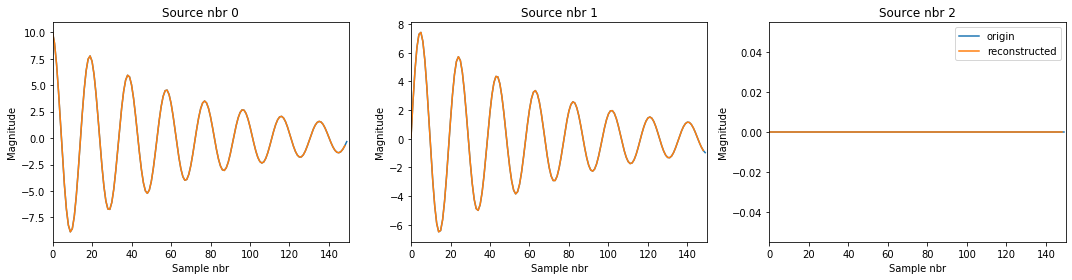

In [4]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    plt.plot(R[i, :], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
plt.legend()
plt.tight_layout()

# Example 2: iSDR order 2

In [5]:
G_2 = np.zeros((n_c, n_s*2))
G_2[:, n_s:] = np.dot(G, A)
cl = ciSDR.linear_model.iSDR_step(l21_ratio=1e-10, tol=1e-12, max_iter=10000)
R = cl.reconstruct(G_2, M, 2)

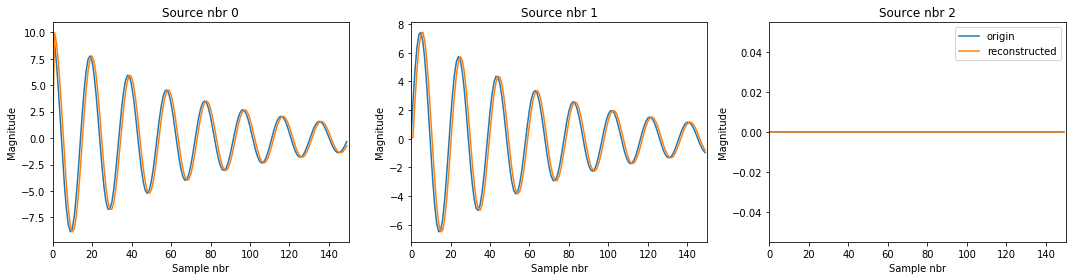

In [6]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    plt.plot(R[i, :], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
plt.legend()
plt.tight_layout()